## This is the Baseline Models Comparison and Selection

<font size="6" color="blue"> <B> I. Baseline Study </B> </font> 

# 1. Load Librares

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
import warnings
%matplotlib inline
plt.style.use('ggplot')

In [109]:
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import model_selection
from sklearn.metrics import explained_variance_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [94]:
# this is pandas table width setting
pd.set_option('display.max_columns', None)  

In [95]:
# display pd table side by side
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# 2. Load the Data

In [155]:
# load train1, test1, rul1 pickle to have a test

train_d = pd.read_pickle('data/train_d.pkl')
test_d = pd.read_pickle('data/test_d.pkl')

train_r = pd.read_pickle('data/train_r.pkl')
test_r = pd.read_pickle('data/test_r.pkl')

train_r_n = pd.read_pickle('data/train_r_n.pkl')
test_r_n = pd.read_pickle('data/test_r_n.pkl')

In [170]:
# Prepare the training / testing data (raw data)

X_train_d, Y_train_d = train_d.iloc[:,2:18], train_d['rul']
X_test_d, Y_test_d = test_d.iloc[:,2:18], test_d['rul']

X_train_r, Y_train_r = train_r.iloc[:,2:18], train_r['rul']
X_test_r, Y_test_r = test_r.iloc[:,2:18], test_r['rul']

X_train_r_n, Y_train_r_n = train_r_n.iloc[:,2:18], train_r_n['rul']
X_test_r_n, Y_test_r_n = test_r_n.iloc[:,2:18], test_r_n['rul']

# 3. Regression

## 3.1 BaseLine

### Support Functions

In [171]:
# define regression metrics calculation

def get_regression_metrics(model_name, model, x_train, y_train, x_test, y_test):

    model.fit(x_train, y_train.values.ravel())
    y_pred = model.predict(x_test)
    
    regression_metrics = {
        'CV explained variance':       cross_val_score(model, x_train, y_train, cv=5, scoring='explained_variance').mean(),
        'CV root mean squared error':  (-cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error').mean())**0.5,
        'CV mean absolute error':      -cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean(),
        'CV r2 score':                 cross_val_score(model, x_train, y_train, cv=5, scoring='r2').mean()
    }
    df_regression_metrics = pd.DataFrame.from_dict(regression_metrics, orient='index')
    df_regression_metrics.columns = [model_name]
    return df_regression_metrics

In [172]:
# define feature importance plot

def plot_feature_importance(model_name, model, x_train, y_train):
    '''Plot regression feature importance (coefficients weights)
    model (str):           model name
    weights (array):       coefficient weights
    f_names (list):        feature names
    weight_type (str):     'c' for coefficient weights, o.w. is feature importance
    returns:               plt of feature importance (coefficient weights)
    '''
    model.fit(x_train, y_train.values.ravel())
    if model_name == 'DecisionTr' or model_name == 'RandomFore':
        W = pd.DataFrame({'weights': model.feature_importances_}, x_train.columns)
    else:
        W = pd.DataFrame({'weights': model.coef_}, x_train.columns)        
    W.sort_values(by='weights', ascending=True).plot(kind='barh', color='r', figsize=(12, 5))
    label = ' feature importance' if (model_name == 'DecisionTr' or model_name == 'RandomFore') else 'coefficients'
    plt.xlabel(model_name + label)
    plt.show()

In [173]:
# define Grid Search Based hyper-parameter adjustment

def best_model(model_name, model, x_train, y_train, x_test, params=None, score=None):
    grid_search = model_selection.GridSearchCV(estimator=model, param_grid=params, cv=5, scoring=score, n_jobs=-1)
    grid_search.fit(x_train, y_train)
    y_pred = grid_search.predict(x_test)
    if hasattr(grid_search, 'predict_proba'):
        y_score = grid_search.predict_prob(x_test)[:,1]
    elif hasattr(grid_search, 'decision_function'):
        y_score = grid_search.decision_function(x_test)
    else:
        y_score = y_pred
    predictions = {'y_pred': y_pred, 'y_score': y_score}
    df_predictions = pd.DataFrame.from_dict(predictions)
    return grid_search.best_estimator_, df_predictions, y_score

### Models

In [188]:
lin_regr = linear_model.LinearRegression()                                         # linear regression
lasso_regr = linear_model.Lasso(alpha=0.1)                                        # LASSO regression
rd_regr = linear_model.Ridge(alpha=0.01)                                           # ridge regression
dtr_regr = DecisionTreeRegressor(max_depth=7, random_state=123)                    # decision tree regression
rf_regr = RandomForestRegressor(n_estimators = 50)                                # random forest regression
list_reg_model_name = [(str(m).split('(')[0][0:10], m) for m in [lin_regr, lasso_regr, rd_regr, dtr_regr, rf_regr]]

### Raw Data: Performance

In [175]:
# Note: due to random forest, this running is pretty slow

newDF = pd.DataFrame()
for name, model in list_reg_model_name:
    newDF = pd.concat([newDF, get_regression_metrics(name, model, X_train_d, Y_train_d, X_test_d, Y_test_d)], axis=1)
newDF

LinearRegr      Lasso      Ridge  DecisionTr  \
CV mean absolute error       47.568809  47.553084  47.562176   48.892844   
CV explained variance         0.482519   0.482773   0.482606    0.452275   
CV r2 score                   0.434779   0.434967   0.434836    0.401211   
CV root mean squared error   60.376919  60.370614  60.374442   62.164313   

                            RandomFore  
CV mean absolute error       47.617575  
CV explained variance         0.488703  
CV r2 score                   0.437090  
CV root mean squared error   60.317257

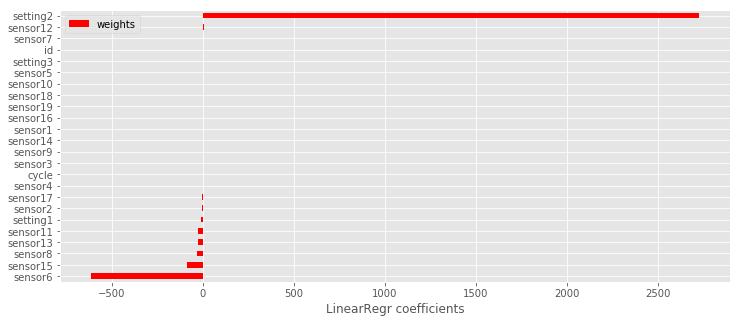

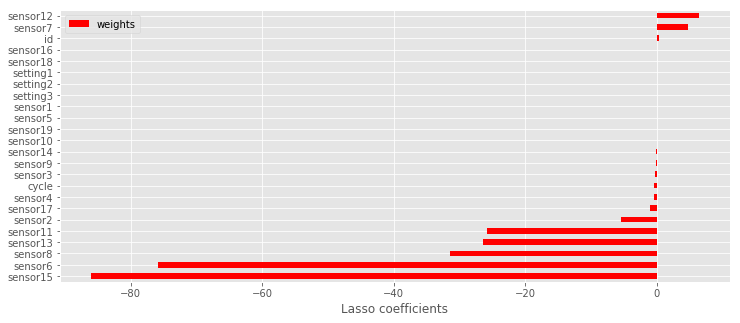

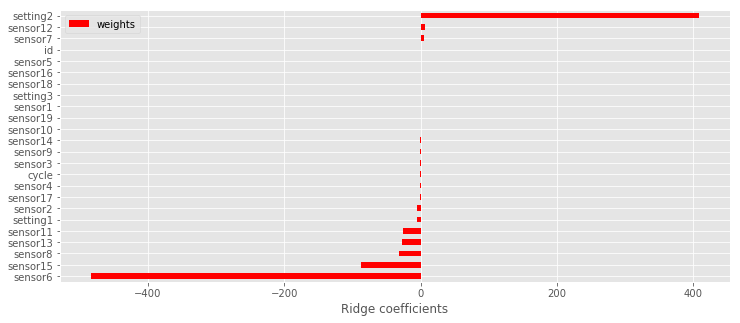

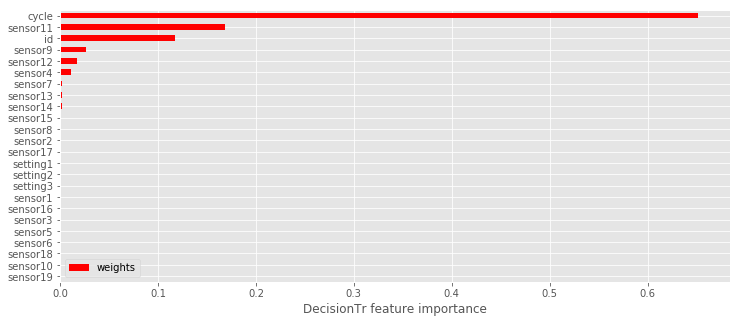

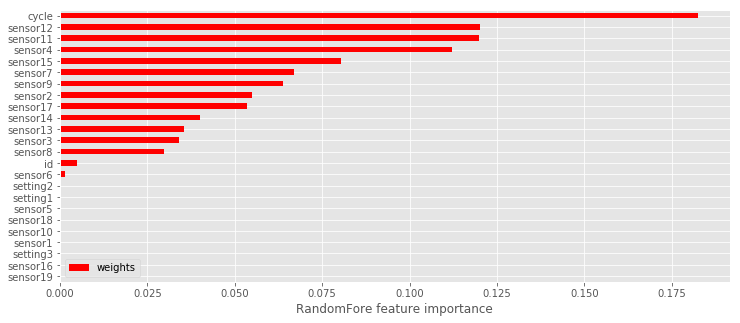

[None, None, None, None, None]

In [85]:
# Feature importance or coefficiency

[plot_feature_importance(name, model, X_train_d, Y_train_d) for name, model in list_reg_model_name]

### Rolling Average Data: Performance

In [191]:
# rolling window = 10

newDF_r = pd.DataFrame()
for name, model in list_reg_model_name:
    newDF_r = pd.concat([newDF_r, get_regression_metrics(name, model, X_train_r, Y_train_r, X_test_r, Y_test_r)], axis=1)
newDF_r

LinearRegr 
 Lasso 
 Ridge 
 DecisionTr 
 RandomFore 
 
 
 
 
 CV mean absolute error 
 47.568809 
 47.553084 
 47.562176 
 48.892844 
 47.617575 
 
 
 CV explained variance 
 0.482519 
 0.482773 
 0.482606 
 0.452275 
 0.488703 
 
 
 CV r2 score 
 0.434779 
 0.434967 
 0.434836 
 0.401211 
 0.437090 
 
 
 CV root mean squared error 
 60.376919 
 60.370614 
 60.374442 
 62.164313 
 60.317257 
 
 
 
 
 
 
 LinearRegr 
 Lasso 
 Ridge 
 DecisionTr 
 RandomFore 
 
 
 
 
 CV mean absolute error 
 47.260862 
 47.500155 
 47.205559 
 50.811148 
 50.498009 
 
 
 CV explained variance 
 0.489431 
 0.484695 
 0.490328 
 0.400980 
 0.424225 
 
 
 CV r2 score 
 0.441840 
 0.436893 
 0.442741 
 0.346745 
 0.365550 
 
 
 CV root mean squared error 
 59.989785 
 60.261216 
 59.944044 
 64.497581 
 63.934477

### Normalization + Rolling: Performance

In [193]:
newDF_r_n = pd.DataFrame()
for name, model in list_reg_model_name:
    newDF_r_n = pd.concat([newDF_r_n, get_regression_metrics(name, model, X_train_r_n, Y_train_r_n, X_test_r_n, Y_test_r_n)], axis=1)
newDF_r_n

LinearRegr     Lasso     Ridge  DecisionTr  \
CV mean absolute error        0.099497  0.139272  0.099495    0.106845   
CV explained variance         0.489431  0.000000  0.489448    0.403702   
CV r2 score                   0.441840 -0.067552  0.441857    0.349200   
CV root mean squared error    0.126294  0.173507  0.126292    0.135594   

                            RandomFore  
CV mean absolute error        0.106272  
CV explained variance         0.424891  
CV r2 score                   0.368801  
CV root mean squared error    0.134721

### Summary
- The models perform very similarly under raw data
- Noise removal (rolling average) helped Linear models but constrained Decision Tree models
- Normalization cannot further help linear model; but see enhancmenet on Decision Tree models
- Next Step: 
    - Plan to chose Linear Regression as BASELINE, since the data itself has linearity along timeseries
    - Will chose Random Forest to adjust parameters for better performance 

## 3.2 Improvement Model

### Random Forest

In [194]:
rf_regr.get_params()

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [195]:
# Tune Randome Forest
    
clf_name = 'random forest'
clf_rf = RandomForestRegressor(random_state=1, min_samples_split=2)
# rf_param = {'n_estimators': [5,10,20,50], 'max_depth': [4,5,6]}

rf_param = {"n_estimators": [5, 10, 20, 30, 50],
              "max_depth": [3, 4, 5, 6, 7, 8],
              "min_samples_split": [2, 3, 4, 5, 6, 7, 8],
              "min_samples_leaf": [1, 2, 3, 5, 10, 20]    }
rf_score = 'r2'
clf_rf, Y_pred, Y_score = best_model(clf_name, clf_rf, X_train_r_n, Y_train_r_n, 
                                     X_test_r_n, params=rf_param, score=rf_score)
print('best parameters:\n', clf_rf)

best parameters:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)


In [221]:
clf_rf_fine = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)
clf_rf_fine.fit(X_train_r_n, Y_train_r_n)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=20, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

In [222]:
scores_rf_fine = cross_val_score(clf_rf_fine, X_train_r_n, Y_train_r_n, cv = 5)
print("Forest forecast accuracy : %0.2f (+/- %0.2f)" % (scores_rf_fine.mean(), scores_rf_fine.std()*2))

Forest forecast accuracy : 0.43 (+/- 0.24)


### Ridge Regression

In [209]:
rd_regr.get_params()

{'alpha': 0.01,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [211]:
# Tune Randome Forest
    
clf_name = 'ridge regression'
clf_rg = linear_model.Ridge(alpha=0.01) 
rg_param = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20, 40, 60, 100]}

rg_score = 'r2'
clf_rg, Y_pred, Y_score = best_model(clf_name, clf_rg, X_train_r_n, Y_train_r_n, 
                                     X_test_r_n, params=rg_param, score=rg_score)
print('best parameters:\n', clf_rg)

best parameters:
 Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


In [215]:
clf_rg_fine = linear_model.Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
clf_rg_fine.fit(X_train_r_n, Y_train_r_n)

Ridge(alpha=60, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [216]:
scores_rg_fine = cross_val_score(clf_rg_fine, X_train_r_n, Y_train_r_n, cv = 5)
print("Ridge accuracy : %0.2f (+/- %0.2f)" % (scores_rg_fine.mean(), scores_rg_fine.std()*2))

Ridge accuracy : 0.44 (+/- 0.25)


### Deep Learning 

In [340]:
# prepare data sequence for RNN

sequence_length = 20

def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values         # matrix of selected features
    num_elements = data_matrix.shape[0]          # rows
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [341]:
# separate 192 lines data into 182 fleest
# fleet 1 = train_d.iloc[0:10, :], fleets = train_d.iloc[1:11, :], so as to build a 3d data sets
# dimension 1 = fleet 1 - 182; dimension 2 = train_d[i, i+10]; dimension 3 = features

sequence_cols = X_train_r_n.columns
val=list(gen_sequence(train_r_n[train_r_n['id']==1], sequence_length, sequence_cols))
print(np.shape(val))

(172, 20, 16)


In [342]:
# genearte training sets (X)

seq_gen = (list(gen_sequence(train_r_n[train_r_n['id']==id], sequence_length, sequence_cols)) for id in train_r_n['id'].unique())
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)    # mask if run below line, generator only run once then disapeear
print(seq_array.shape)                                          # mask if run below line, generator only run once then disapeear

(18631, 20, 16)


In [343]:
# this is only to show the dimensions of the se_gen (but generate exhausted data after just one running)
for i,j in zip(seq_gen,range(5)): print(np.shape(i))

In [344]:
# generate labels

def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[sequence_length:num_elements, :]

In [345]:
# training label (Y)

label_gen = [gen_labels(train_r_n[train_r_n['id']==id], sequence_length, ['rul']) for id in train_r_n['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)

(18631, 1)


In [346]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

from sklearn import preprocessing

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model.h5'

In [348]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(LSTM(input_shape=(sequence_length, nb_features), units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

print(model.summary())

# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 20, 100)           46800     
_________________________________________________________________
dropout_13 (Dropout)         (None, 20, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                30200     
_________________________________________________________________
dropout_14 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_7 (Activation)    (None, 1)                 0         
Total params: 77,051
Trainable params: 77,051
Non-trainable params: 0
_________________________________________________________________
None
T